# Setup

In [1]:
import os
import sys
import subprocess
import math

import numpy as np
import pandas as pd
from matplotlib import pyplot as pl
import seaborn as sns
import scipy as sp

import anndata as ad
import scanpy as sc

### User variables

In [2]:
RUN_ID = "sep8"

In [3]:
PROJ_ROOT = "/home/fichtner/projects/footprintQTL"
HCA_BORGS_PROJ = "data/datasets/hca_brain-organoids/"
ATAC_PEAKS_PATH = "data/datasets/hca_brain-organoids_processed/chromatin_accessibility/peak-matrix_rna-qc-cells_norm-reads-in-tss.h5ad"
RNA_AD_PATH = os.path.join(HCA_BORGS_PROJ, "outputs_allsamples/sabrina_allsamples_rna_after_atac.h5ad")

In [4]:
bedtools_bin = '/home/fichtner/.conda/envs/ian/bin/bedtools'

In [5]:
min_donors= 0.2 # Minimum percentage of donors (cell aggregates) a peak needs to be found in AKA Peak sparsity filter
min_cells = 10 # Minimum amount of cells a peak needs to for the peak to be retained (required for functions to work)
cell_type = str("Midbrain EN")
min_pval = 0.01 # Min p-value for marker peaks to be considered in the first place in differential peak accessibility
top_n_markers = 2000 # Top n ranking markers peaks to consider
min_peak_mean_adonors = 0.002 # Minimum threshold of peak mean across donors# Convert sparse matrix to dense format if necessary
min_score = 9 # Minimum score (resulting -log10(q-val) of peak calling w MACS2

### Variables

In [6]:
os.chdir(PROJ_ROOT)

sys.path.append(os.path.join(PROJ_ROOT, "code"))
from helpers.helpers import ct_format, ct_format_alt

In [7]:
cell_type_alt = ct_format_alt(cell_type)
cell_type = ct_format(cell_type)

### Artifact donors

In [8]:
# # TMP
# PROJECT_PATH = '/home/fichtner/projects/footprintQTL'
# DATA_PATH = '/omics/groups/OE0540/internal/projects/HCA_organoid_2/cemm_sabrina-20Jul2022/'
# RNA_AD = 'outputs_allsamples/sabrina_allsamples_rna_final_after_atac.h5ad'

# import sys
# sys.path.append(PROJECT_PATH + "/code")
# from helpers.helpers import ct_format, get_anndata_coldata

# cells_coldata = get_anndata_coldata(os.path.join(DATA_PATH, RNA_AD))[0]
# del cells_coldata

In [9]:
# Exclude for some weird reason, samples in QC but not in other files
artifact_donors = {'SAMEA2474458', 'SAMEA2555012'}

# Get data

## Chromatin accessibility cell-level anndata

In [10]:
borgs_tile_mat = ad.read_h5ad(ATAC_PEAKS_PATH)

# Format
borgs_tile_mat.var_names = borgs_tile_mat.var['peak_name']
borgs_tile_mat.obs['celltype'] = borgs_tile_mat.obs['celltype'].apply(ct_format).astype('category')

borgs_tile_mat

/home/fichtner/.conda/envs/ian/lib/python3.9/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 288900 × 736845
    obs: 'BlacklistRatio', 'nDiFrags', 'nFrags', 'nMonoFrags', 'nMultiFrags', 'NucleosomeRatio', 'PassQC', 'PromoterRatio', 'ReadsInBlacklist', 'ReadsInPromoter', 'ReadsInTSS', 'Sample', 'TSSEnrichment', 'celltype', 'cellType', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'donor_id', 'clone', 'organoid', 'donor', 'leiden', 'stressed_vs_unstressed_celltypes', 'Batch', 'ReadsInPeaks', 'FRIP', 'barcode'
    var: 'chr', 'start', 'end', 'strand', 'peak_name', 'score', 'GC', 'nearest_gene', 'peak_type'

In [11]:
# Remove artifact donors
donors_qc = ~borgs_tile_mat.obs['donor_id'].isin(artifact_donors)

borgs_tile_mat = borgs_tile_mat[donors_qc, :].copy()

borgs_tile_mat.shape

(284522, 736845)

### Get cell-type anndata

In [12]:
caPeaks_1ct = borgs_tile_mat[borgs_tile_mat.obs['celltype'] == cell_type, :].copy()
caPeaks_1ct

AnnData object with n_obs × n_vars = 24838 × 736845
    obs: 'BlacklistRatio', 'nDiFrags', 'nFrags', 'nMonoFrags', 'nMultiFrags', 'NucleosomeRatio', 'PassQC', 'PromoterRatio', 'ReadsInBlacklist', 'ReadsInPromoter', 'ReadsInTSS', 'Sample', 'TSSEnrichment', 'celltype', 'cellType', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'donor_id', 'clone', 'organoid', 'donor', 'leiden', 'stressed_vs_unstressed_celltypes', 'Batch', 'ReadsInPeaks', 'FRIP', 'barcode'
    var: 'chr', 'start', 'end', 'strand', 'peak_name', 'score', 'GC', 'nearest_gene', 'peak_type'

In [13]:
n_peaks_og = caPeaks_1ct.n_vars

### Hard peak filter: Remove peaks w min cell nr

In [14]:
# Required for HVPeaks or DAPeaks algorithms
sc.pp.filter_genes(caPeaks_1ct, min_cells=min_cells)
n_cells, n_peaks_post_min_cells = caPeaks_1ct.shape
caPeaks_1ct.shape

(24838, 713283)

In [15]:
n_peaks_min_cells = n_peaks_og - n_peaks_post_min_cells

In [16]:
# Remove hard-filtered peaks from cell-level anndata = borgs_tile_mat[].
# borgs_tile_mat = borgs_tile_mat[].
borgs_tile_mat = borgs_tile_mat[:, caPeaks_1ct.var_names].copy()

### Cell-type cells level stats

In [17]:
# describe_result = sp.stats.describe(caPeaks_1ct.X.toarray(), axis=0)

# stats = {
#     'nobs': [describe_result.nobs] * len(describe_result.mean),
#     'min': describe_result.minmax[0],
#     'max': describe_result.minmax[1],
#     'mean': describe_result.mean,
#     'variance': describe_result.variance,
#     'skewness': describe_result.skewness,
#     'kurtosis': describe_result.kurtosis
# }

# # Create a DataFrame with the statistics
# df = pd.DataFrame(stats)
# df = df.transpose().reset_index().rename(columns={'index': 'statistic'}).set_index('statistic')

# df

### Init donor-level CA matrix

In [18]:
caPeaks_1ct_agg = sc.get.aggregate(caPeaks_1ct,
                                   by=['donor_id'],
                                   func=['mean'],
                                   axis='obs')

caPeaks_1ct_agg.X = caPeaks_1ct_agg.layers['mean'].copy()
del caPeaks_1ct_agg.layers['mean']

n_donors = caPeaks_1ct_agg.n_obs

caPeaks_1ct_agg

AnnData object with n_obs × n_vars = 69 × 713283
    obs: 'donor_id'
    var: 'chr', 'start', 'end', 'strand', 'peak_name', 'score', 'GC', 'nearest_gene', 'peak_type', 'n_cells'

In [19]:
agg_df = caPeaks_1ct_agg.to_df()
agg_df

peak_name,chr1:804695:805195:501:*:1,chr1:811018:811518:501:*:2,chr1:817077:817577:501:*:3,chr1:817816:818316:501:*:4,chr1:819782:820282:501:*:5,chr1:826617:827117:501:*:6,chr1:827319:827819:501:*:7,chr1:830673:831173:501:*:8,chr1:838258:838758:501:*:9,chr1:849809:850309:501:*:10,...,chrX:155880442:155880942:501:*:19669,chrX:155881013:155881513:501:*:19670,chrX:155881586:155882086:501:*:19671,chrX:155888143:155888643:501:*:19672,chrX:155889305:155889805:501:*:19673,chrX:155891803:155892303:501:*:19674,chrX:155941826:155942326:501:*:19675,chrX:155956608:155957108:501:*:19676,chrX:155959222:155959722:501:*:19677,chrX:155966839:155967339:501:*:19678
SAMEA2420640,0.006431,0.000000,0.000000,0.000000,0.006120,0.004066,0.038638,0.000000,0.000000,0.002154,...,0.003693,0.074383,0.005760,0.000000,0.000000,0.0,0.000000,0.001232,0.000000,0.019910
SAMEA2433566,0.002148,0.000000,0.000000,0.000000,0.000000,0.008085,0.044146,0.000000,0.000000,0.000616,...,0.006065,0.075536,0.006310,0.000000,0.000000,0.0,0.000897,0.000796,0.000000,0.000000
SAMEA2445779,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.154036,0.000000,0.000000,0.000000,...,0.000000,0.123713,0.000000,0.000000,0.000000,0.0,0.129495,0.000000,0.000000,0.000000
SAMEA2445784,0.000000,0.000000,0.004945,0.000000,0.003225,0.025578,0.083477,0.000000,0.000000,0.013318,...,0.010357,0.064488,0.002739,0.001293,0.000000,0.0,0.000000,0.000000,0.000000,0.000881
SAMEA2459959,0.000000,0.000000,0.000986,0.001302,0.000000,0.035435,0.077227,0.000000,0.000000,0.016741,...,0.001668,0.053727,0.001870,0.000000,0.003381,0.0,0.000000,0.001176,0.000000,0.011510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SAMEA3977051,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.046828,0.000000,0.000000,0.000000,...,0.000000,0.071044,0.012016,0.000000,0.000000,0.0,0.055041,0.000000,0.000000,0.000000
SAMEA4089453,0.001204,0.000197,0.003589,0.002221,0.000371,0.009407,0.063357,0.000283,0.000000,0.015223,...,0.008106,0.055829,0.015868,0.000000,0.000882,0.0,0.000000,0.003267,0.000947,0.000658
SAMEA4343052,0.000000,0.000000,0.261278,0.000000,0.000000,0.000000,0.359562,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.130639,0.000000,0.000000
SAMEA4451098,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000


### Init donor-batch-level CA matrix

In [20]:
caPeaks_agg_cdb = sc.get.aggregate(borgs_tile_mat,
                                   by=['celltype', 'donor_id', 'Batch'],
                                   func=['mean'],
                                   axis='obs')

caPeaks_agg_cdb.X = caPeaks_agg_cdb.layers['mean'].copy()
del caPeaks_agg_cdb.layers['mean']

n_donor_batch = caPeaks_agg_cdb.obs[caPeaks_agg_cdb.obs['celltype'] == cell_type].shape[0]

caPeaks_agg_cdb

AnnData object with n_obs × n_vars = 3440 × 713283
    obs: 'celltype', 'donor_id', 'Batch'
    var: 'chr', 'start', 'end', 'strand', 'peak_name', 'score', 'GC', 'nearest_gene', 'peak_type'

# Cell-level analysis

## Peak filter: DAPeaks

In [21]:
from scipy.sparse import csr_matrix, issparse

if issparse(caPeaks_agg_cdb.X):
    print("SCIPY sparse matrix.")
    if np.any(caPeaks_agg_cdb.X.data < 0):
        print("There are negative values in the sparse data matrix.")
    else:
        print("No negative values in the sparse data matrix.")
else:
    print(f"X type:\n{type(caPeaks_agg_cdb.X)}")
    if np.any(caPeaks_agg_cdb.X < 0):
        print("There are negative values in the dense data matrix.")
    else:
        print("No negative values in the dense data matrix.")

X type:
<class 'numpy.ndarray'>


No negative values in the dense data matrix.


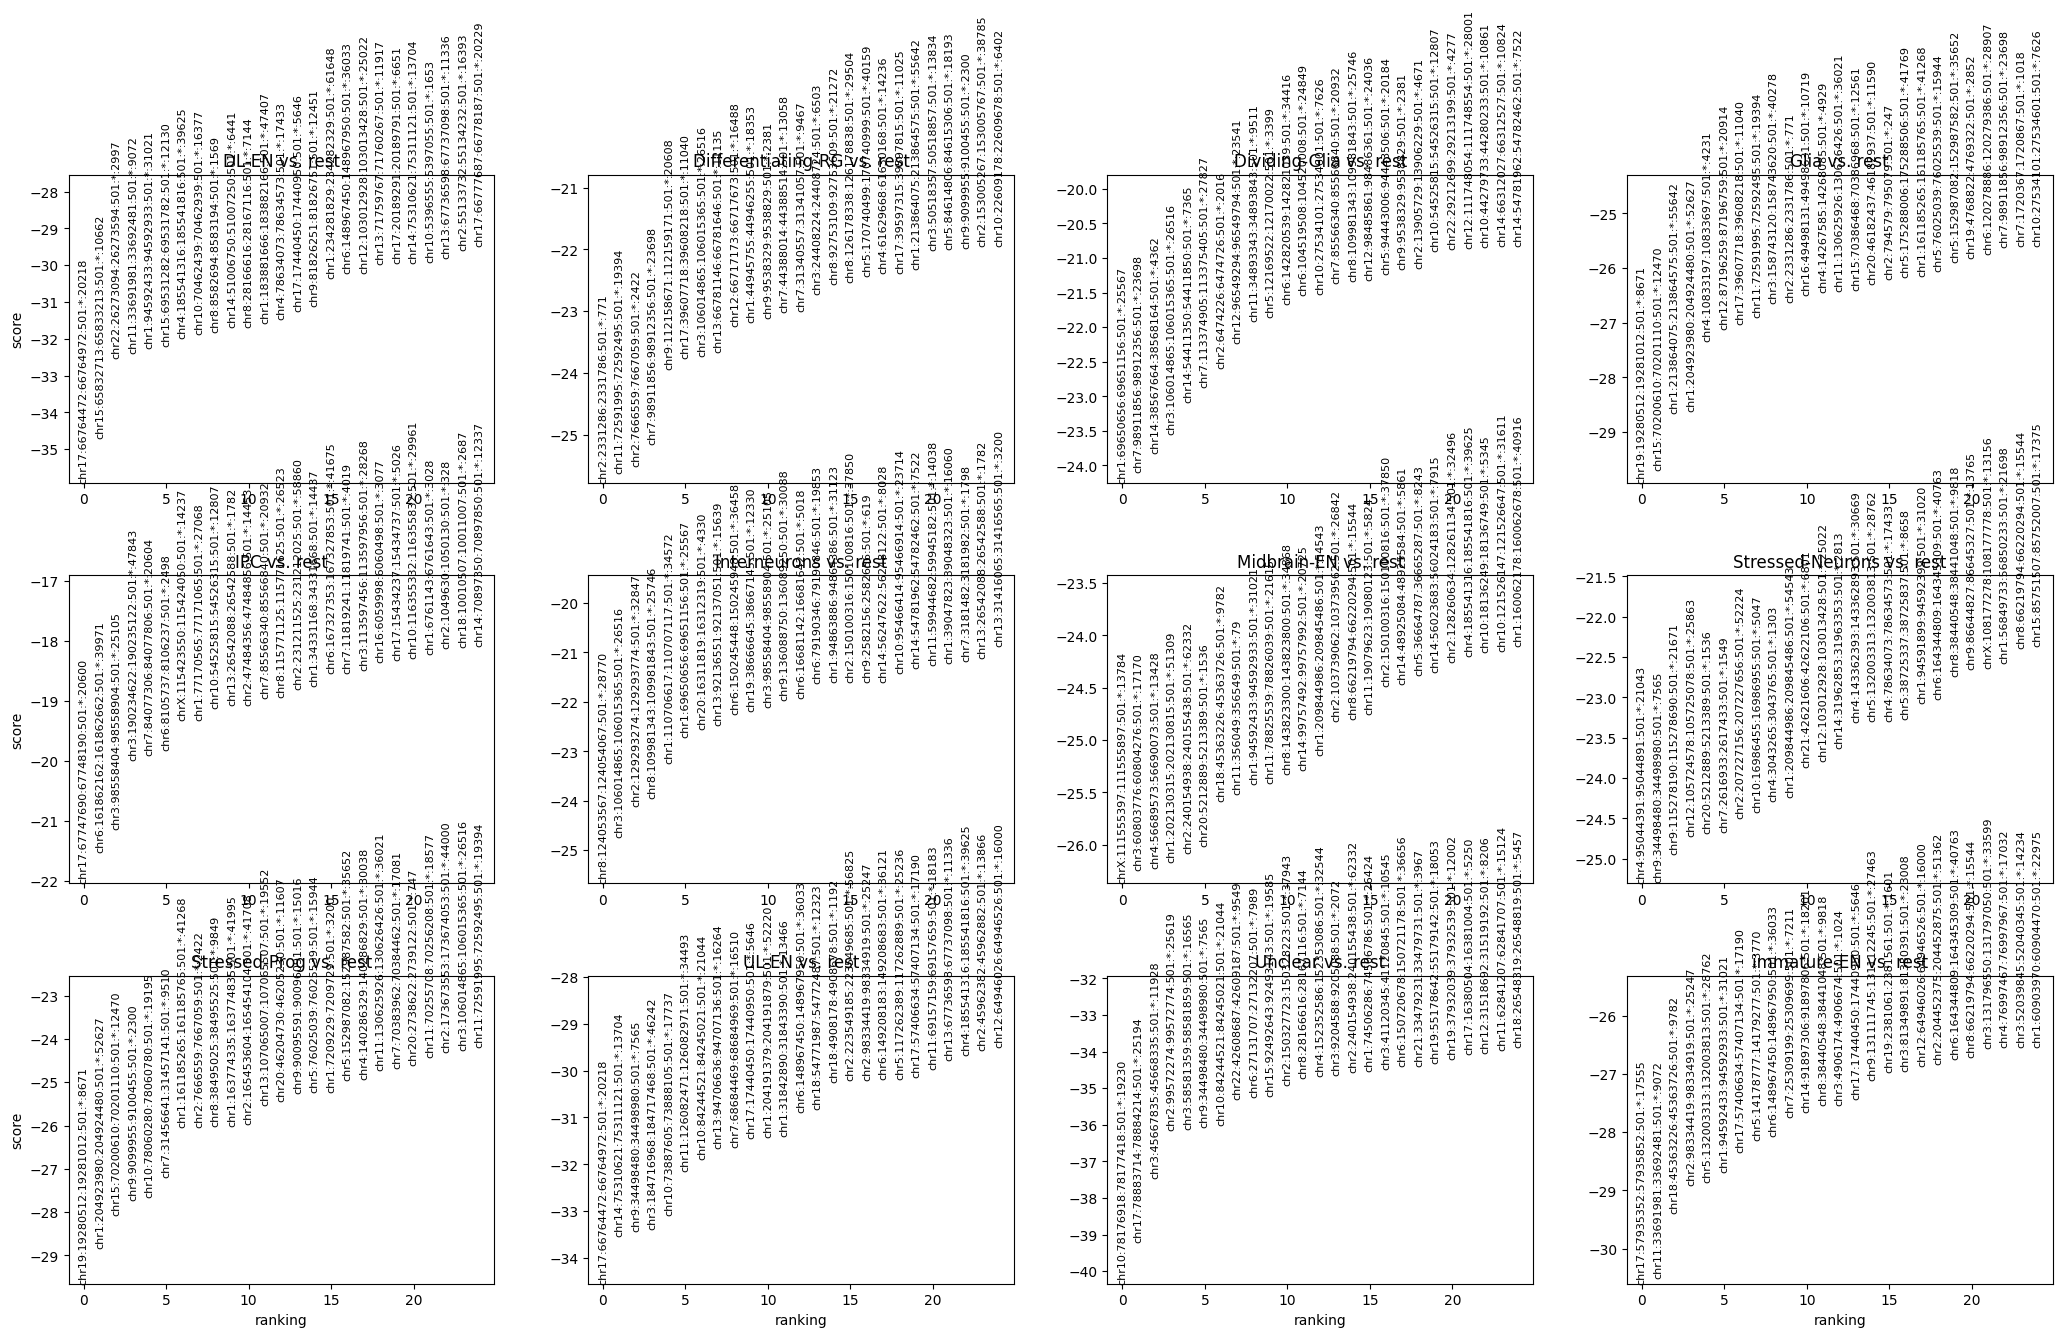

In [22]:
sc.tl.rank_genes_groups(caPeaks_agg_cdb, groupby='celltype', method='t-test', rankby_abs=True)
sc.pl.rank_genes_groups(caPeaks_agg_cdb, n_genes=25, sharey=False)

In [23]:
daps = sc.get.rank_genes_groups_df(caPeaks_agg_cdb, group=cell_type, pval_cutoff=min_pval)
peaks_markers = set(daps['names'][0:top_n_markers])
daps

,names,scores,logfoldchanges,pvals,pvals_adj
0,chrX:111555397:111555897:501:*:13784,-26.368973,-4.413423,1.098007e-139,7.831899e-134
1,chr3:60803776:60804276:501:*:17170,-26.241650,-3.531652,4.252953e-137,1.011186e-131
2,chr4:56689573:56690073:501:*:13428,-26.221449,-3.784201,5.660562e-134,6.729304e-129
3,chr1:202130315:202130815:501:*:51309,-26.166126,-3.536379,2.015444e-137,7.187911e-132
4,chr2:240154938:240155438:501:*:62332,-26.081896,-2.833464,1.253067e-134,1.787582e-129
...,...,...,...,...,...
145387,chr5:41413038:41413538:501:*:9097,-3.087730,-3.479392,2.033764e-03,9.980663e-03
145388,chr4:58103807:58104307:501:*:13753,-3.087618,-1.854577,2.035765e-03,9.988728e-03
145389,chr6:2961920:2962420:501:*:793,-3.087612,-1.503776,2.035252e-03,9.986797e-03
145390,chr3:17292864:17293364:501:*:5073,-3.087496,-2.621763,2.034680e-03,9.984333e-03


In [24]:
daps.to_csv(f"data/datasets/hca_brain-organoids_processed/chromatin_accessibility/differentially-accessible-peaks_{cell_type}.tsv",
            sep='\t')

In [25]:
del caPeaks_agg_cdb

## Peaks filter: intersecting w eQTLs

### Make eQTLs bed file

In [26]:
eqtls = pd.read_csv(os.path.join(HCA_BORGS_PROJ, "eQTL_mapping/eSNPs_significant_all_celltypes_HVGs.tsv"),
                   sep='\t',
                   header=0,
                   index_col=21)
eqtls.columns

Index(['snp_id', 'p_value', 'beta', 'beta_se', 'empirical_feature_p_value',
       'feature_chromosome', 'feature_start', 'feature_end', 'gene_name',
       'n_samples', 'n_e_samples', 'alpha_param', 'beta_param', 'rho',
       'snp_chromosome', 'snp_position', 'assessed_allele', 'call_rate', 'maf',
       'hwe_p', 'feature_id', 'global_corrected_pValue',
       'global_corrected_pValue_BH', 'global_corrected_pValue_BF', 'celltype'],
      dtype='object')

In [27]:
eqtls

,snp_id,p_value,beta,beta_se,empirical_feature_p_value,feature_chromosome,feature_start,feature_end,gene_name,n_samples,...,snp_position,assessed_allele,call_rate,maf,hwe_p,feature_id,global_corrected_pValue,global_corrected_pValue_BH,global_corrected_pValue_BF,celltype
QTL,,,,,,,,,,,,,,,,,,,,,
ENSG00000269376-chr13_112983450_T_C,chr13_112983450_T_C,0.000066,-0.364427,0.092665,0.000000e+00,13,113009671,113010319,NaN,277,...,112983450,C,1.0,0.044776,1.000000,ENSG00000269376,0.000000e+00,0.000000e+00,0.000000e+00,immature_EN
ENSG00000183463-chr13_27824764_C_T,chr13_27824764_C_T,0.047441,-0.089739,0.045430,0.000000e+00,13,27977717,27988693,URAD,277,...,27824764,C,1.0,0.089552,0.073438,ENSG00000183463,0.000000e+00,0.000000e+00,0.000000e+00,immature_EN
ENSG00000259182-chr15_101221494_A_C,chr15_101221494_A_C,0.202509,-0.088910,0.069866,0.000000e+00,15,101168530,101170821,NaN,277,...,101221494,A,1.0,0.044776,0.110206,ENSG00000259182,0.000000e+00,0.000000e+00,0.000000e+00,immature_EN
ENSG00000286922-chr12_127567286_A_G,chr12_127567286_A_G,0.265404,-0.030918,0.027792,0.000000e+00,12,127486938,127533242,NaN,277,...,127567286,G,1.0,0.074627,1.000000,ENSG00000286922,0.000000e+00,0.000000e+00,0.000000e+00,immature_EN
ENSG00000286246-chr12_129375924_C_G,chr12_129375924_C_G,0.949835,-0.000101,0.001608,4.101945e-163,12,129622929,129625366,NaN,277,...,129375924,C,1.0,0.089552,0.073438,ENSG00000286246,1.930191e-161,2.223254e-161,1.111627e-160,immature_EN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000250842-chr5_145190494_A_T,chr5_145190494_A_T,0.000033,0.535958,0.130797,1.828702e-02,5,145337932,145381670,NaN,310,...,145190494,A,1.0,0.316176,1.000000,ENSG00000250842,4.610052e-02,4.610052e-02,1.000000e+00,Differentiating_RG
ENSG00000267537-chr19_28873752_G_A,chr19_28873752_G_A,0.000285,-0.620958,0.172965,1.854836e-02,19,28602379,28648303,NaN,310,...,28873752,G,1.0,0.066176,0.246147,ENSG00000267537,4.669823e-02,4.669823e-02,1.000000e+00,Differentiating_RG
ENSG00000287056-chr6_168100952_C_G,chr6_168100952_C_G,0.001926,-0.216988,0.070509,1.932144e-02,6,168217032,168220262,NaN,310,...,168100952,C,1.0,0.102941,1.000000,ENSG00000287056,4.858106e-02,4.858106e-02,1.000000e+00,Differentiating_RG


In [28]:
eqtls['celltype'].unique()

array(['immature_EN', 'Stressed_Prog', 'IPC', 'Glia', 'UL-EN',
       'Midbrain_EN', 'Dividing_Glia', 'DL-EN', 'Interneurons',
       'Stressed_Neurons', 'Differentiating_RG'], dtype=object)

In [29]:
cell_type_alt

'Midbrain_EN'

In [30]:
# Make eQTL bed file

eqtls_bed = eqtls[['snp_chromosome', 'snp_position', 'beta']].copy()
# eqtls_bed = eqtls.loc[eqtls['celltype'] == cell_type_alt, ['snp_chromosome', 'snp_position', 'beta']]

eqtls_bed['start'] = eqtls_bed['snp_position'] - 1 # Make index 0-based open
eqtls_bed['strand'] = '+'
eqtls_bed.reset_index(inplace=True)
eqtls_bed['chr'] = 'chr' + eqtls_bed['snp_chromosome'].astype(str)
eqtls_bed = eqtls_bed.rename(columns={'snp_position': 'end', 'QTL': 'id', 'beta': 'score'})

eqtls_bed = eqtls_bed[['chr', 'start', 'end', 'id', 'score', 'strand']].sort_values(by=['chr', 'start'], ascending=[True, True])
        
eqtls_bed_path = f'data/datasets/hca_brain-organoids_processed/eQTLs/eQTLs_{cell_type}.tsv'
eqtls_bed.to_csv(eqtls_bed_path, sep='\t', header=False, index=False)

print(len(eqtls_bed))
eqtls_bed

2470


,chr,start,end,id,score,strand
921,chr1,1050079,1050080,ENSG00000186827-chr1_1050080_T_C,-0.002860,+
818,chr1,1169857,1169858,ENSG00000187961-chr1_1169858_T_C,0.436706,+
1967,chr1,1254680,1254681,ENSG00000225285-chr1_1254681_A_G,-0.251069,+
897,chr1,2283681,2283682,ENSG00000272161-chr1_2283682_C_T,-0.000118,+
1906,chr1,2370251,2370252,ENSG00000224387-chr1_2370252_G_A,-0.000220,+
...,...,...,...,...,...,...
478,chr9,136443069,136443070,ENSG00000279141-chr9_136443070_G_A,-0.020974,+
789,chr9,136937291,136937292,ENSG00000184709-chr9_136937292_T_C,1.331115,+
2163,chr9,137021089,137021090,ENSG00000275549-chr9_137021090_C_T,-0.005619,+
805,chr9,137096077,137096078,ENSG00000176884-chr9_137096078_T_C,0.652370,+


### Make peaks bed file

In [31]:
peaks_bed = borgs_tile_mat.var[['chr', 'start', 'end', 'peak_name', 'score']].copy()
peaks_bed['start'] = peaks_bed['start'] - 1
peaks_bed['strand'] = '+'

peaks_bed_path = f'data/datasets/hca_brain-organoids_processed/chromatin_accessibility/peaks_{cell_type}.bed'
peaks_bed.to_csv(peaks_bed_path, sep='\t', header=False, index=False)

print(len(peaks_bed))
peaks_bed

713283


,chr,start,end,peak_name,score,strand
peak_name,,,,,,
chr1:804695:805195:501:*:1,chr1,804694,805195,chr1:804695:805195:501:*:1,3.01127,+
chr1:811018:811518:501:*:2,chr1,811017,811518,chr1:811018:811518:501:*:2,17.72120,+
chr1:817077:817577:501:*:3,chr1,817076,817577,chr1:817077:817577:501:*:3,19.46110,+
chr1:817816:818316:501:*:4,chr1,817815,818316,chr1:817816:818316:501:*:4,10.06330,+
chr1:819782:820282:501:*:5,chr1,819781,820282,chr1:819782:820282:501:*:5,2.71269,+
...,...,...,...,...,...,...
chrX:155891803:155892303:501:*:19674,chrX,155891802,155892303,chrX:155891803:155892303:501:*:19674,11.25430,+
chrX:155941826:155942326:501:*:19675,chrX,155941825,155942326,chrX:155941826:155942326:501:*:19675,9.46511,+
chrX:155956608:155957108:501:*:19676,chrX,155956607,155957108,chrX:155956608:155957108:501:*:19676,42.66500,+


### Peaks intersecting w eQTLs

In [32]:
try:
    result = subprocess.run([bedtools_bin, 'intersect' , '-a', peaks_bed_path, '-b', eqtls_bed_path, '-u'], text=True, capture_output=True)

    with open(f'data/datasets/hca_brain-organoids_processed/chromatin_accessibility/peaks_{cell_type}_filt-eqtls.bed', 'w') as f:
        f.write(result.stdout)

    peaks_eqtl = set([i.split('\t')[3] for i in result.stdout.split('\n')[:-1]])
    
except subprocess.CalledProcessError as e:
    
    print(f"Command failed with error: {e.stderr}")

In [33]:
del borgs_tile_mat

# Cell-type level analysis

### Peak filter: HVPeaks

In [34]:
# Remove batches w with min cell nr
cell_counts_per_donor_batch = caPeaks_1ct.obs.groupby('Batch').transform('size')
ca_1ct_batch_filtered = caPeaks_1ct[cell_counts_per_donor_batch >= 10, :].copy()
sum(cell_counts_per_donor_batch >= 10)

24838

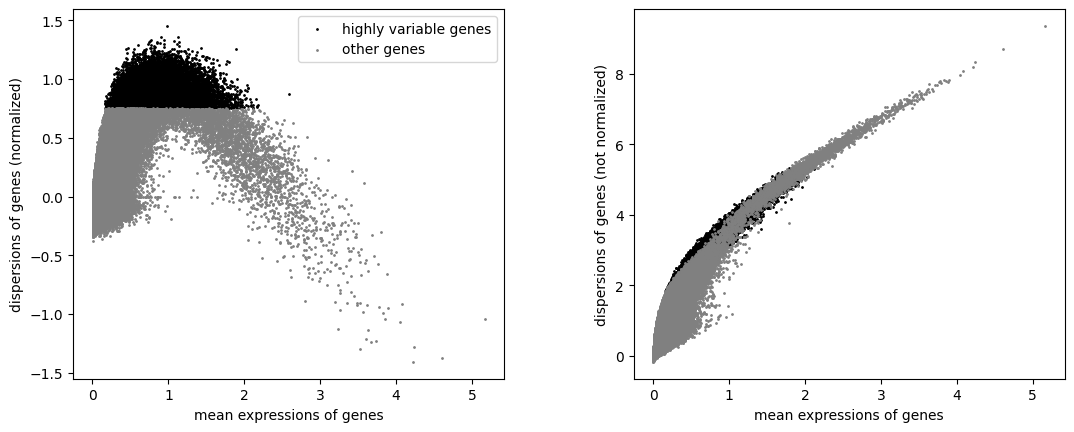

In [35]:
# Seurat (expect log)
sc.pp.highly_variable_genes(ca_1ct_batch_filtered, flavor='seurat', batch_key='Batch', min_mean=0.0005, max_mean=3, min_disp=0.75)
sc.pl.highly_variable_genes(ca_1ct_batch_filtered)

In [36]:
peaks_hvp = set(ca_1ct_batch_filtered.var[ca_1ct_batch_filtered.var['highly_variable']].index)

In [37]:
# !!! Below all change .var['highly_variable'], but it's okay if we don't use that info anymore downstream

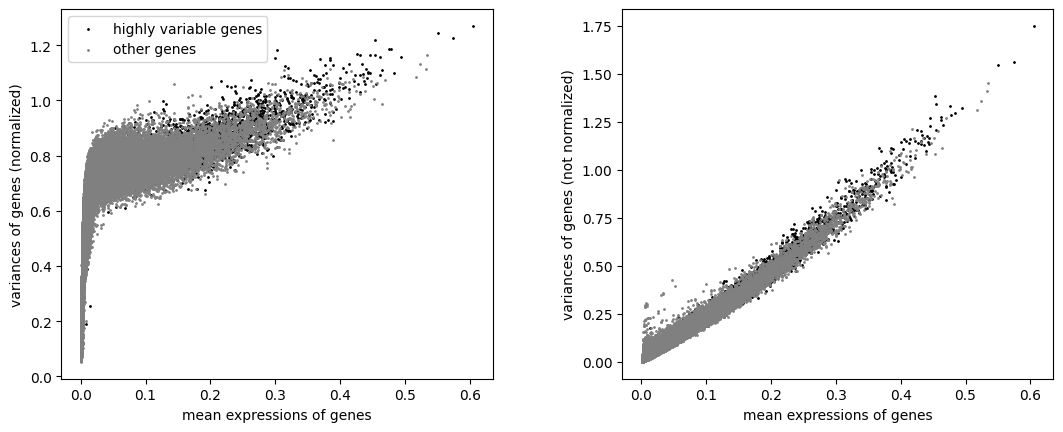

In [38]:
# Seurat_3 (expects counts)
sc.pp.highly_variable_genes(ca_1ct_batch_filtered, flavor='seurat_v3', batch_key='Batch', n_top_genes=20000, check_values=False, span= 0.5)
sc.pl.highly_variable_genes(ca_1ct_batch_filtered)

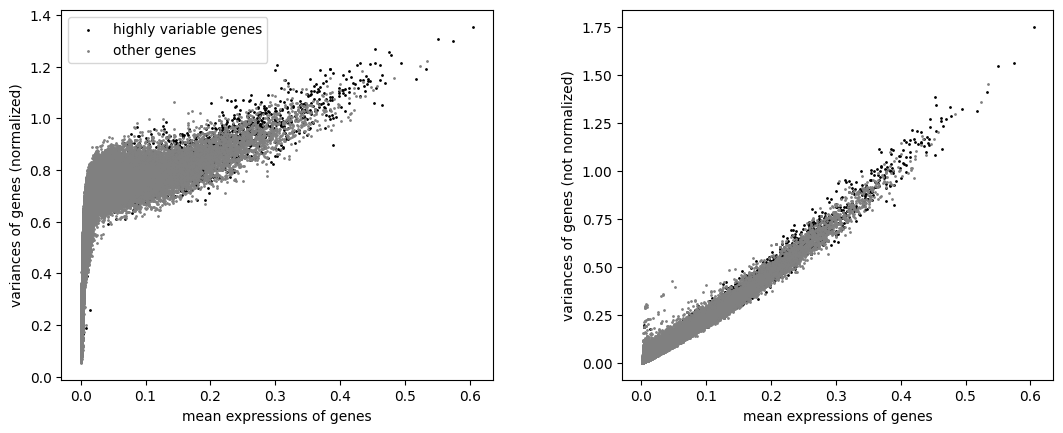

In [39]:
# Seurat_3 (expects counts)
sc.pp.highly_variable_genes(ca_1ct_batch_filtered, flavor='seurat_v3', batch_key='Batch', n_top_genes=20000, check_values=False, span= 0.7)
sc.pl.highly_variable_genes(ca_1ct_batch_filtered)

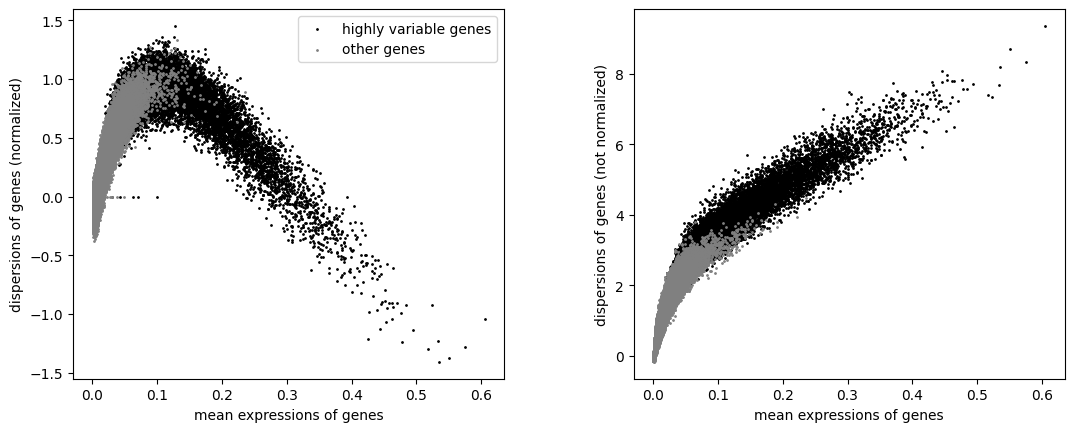

In [40]:
# Pearson residuals (expects counts)
sc.experimental.pp.highly_variable_genes(ca_1ct_batch_filtered, flavor='pearson_residuals', theta=100, batch_key='Batch', n_top_genes=20000, check_values=False)
sc.pl.highly_variable_genes(ca_1ct_batch_filtered)

In [41]:
from scipy.sparse import issparse

# Convert sparse matrix to dense format if necessary
data_matrix = caPeaks_1ct.X.toarray() if issparse(caPeaks_1ct.X) else caPeaks_1ct.X

# Check for NaN values
print("Number of NaN values in data:", np.isnan(data_matrix).sum())

# Check for infinite values
print("Number of infinite values in data:", np.isinf(data_matrix).sum())

# Check for rows with all zeros (optimized for sparse matrices)
if issparse(caPeaks_1ct.X):
    zero_rows = np.array((caPeaks_1ct.X != 0).sum(axis=1)).flatten() == 0
else:
    zero_rows = np.sum(data_matrix == 0, axis=1) == data_matrix.shape[1]

print("Number of rows with all zero values:", zero_rows.sum())

Number of NaN values in data: 0


Number of infinite values in data: 0


Number of rows with all zero values: 0


In [42]:
# caPeaks_1ct.layers['og'] = caPeaks_1ct.X.copy()

# sc.pp.log1p(caPeaks_1ct)

In [43]:
# # Seurat (expect log)
# sc.pp.highly_variable_genes(caPeaks_1ct, flavor='seurat', batch_key='Batch', min_mean=0.0125, max_mean=3, min_disp=0.5)
# sc.pl.highly_variable_genes(caPeaks_1ct)

In [44]:
# # Seurat_3 (expects counts)
# sc.pp.highly_variable_genes(caPeaks_1ct, flavor='seurat_v3', batch_key='Batch', n_top_genes=50000, check_values=False, span= 0.5)
# sc.pl.highly_variable_genes(caPeaks_1ct)

In [45]:
# caPeaks_1ct.X = caPeaks_1ct.layers['og'].copy()
# del caPeaks_1ct.layers['og']

In [46]:
del ca_1ct_batch_filtered

## Peaks filter: min mean across donors

In [47]:
agg_mean = agg_df.mean()

In [48]:
agg_mean.describe()

count    713283.000000
mean          0.007522
std           0.021552
min           0.000063
25%           0.000976
50%           0.002151
75%           0.005359
max           0.621060
dtype: float64

<Axes: title={'center': 'Peak mean across donors distr.'}, ylabel='#'>

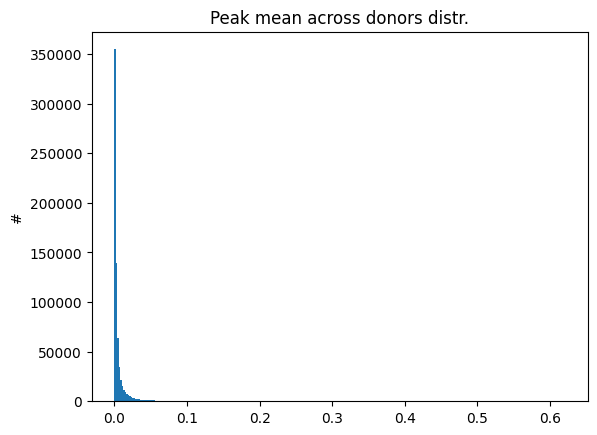

In [49]:
agg_mean.plot(kind='hist',
              bins=300, title="Peak mean across donors distr.",
              xlabel="",
              ylabel="#")

<Axes: title={'center': 'Peak mean across donors ZOOM distr.'}, ylabel='#'>

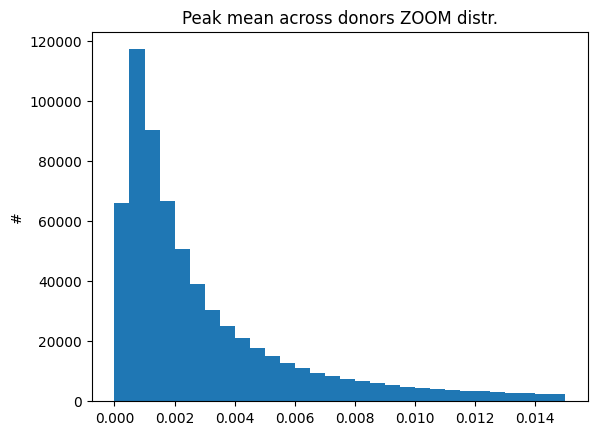

In [50]:
agg_mean.plot(kind='hist', 
              bins=np.linspace(0, 0.015, 31),
              title="Peak mean across donors ZOOM distr.",
              xlabel="",
              ylabel="#")

<Axes: title={'center': 'Peak mean across donors ZOOM distr.'}, ylabel='Density'>

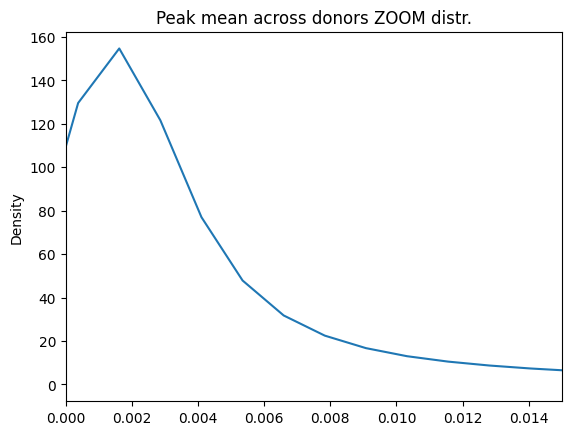

In [51]:
agg_mean.plot(kind='density',
              xlim=[0, 0.015],
              title="Peak mean across donors ZOOM distr.",
              xlabel="")

In [52]:
peaks_min_mean = set(agg_df.loc[:, agg_mean > min_peak_mean_adonors].columns.tolist())

## Peaks filter: min donors with non-zero ca count

In [53]:
non0s = (agg_df != 0).mean()

non0s.describe()

count    713283.000000
mean          0.406977
std           0.183498
min           0.057971
25%           0.260870
50%           0.376812
75%           0.521739
max           1.000000
dtype: float64

<Axes: title={'center': 'Non-zero donor count distr.'}, ylabel='#'>

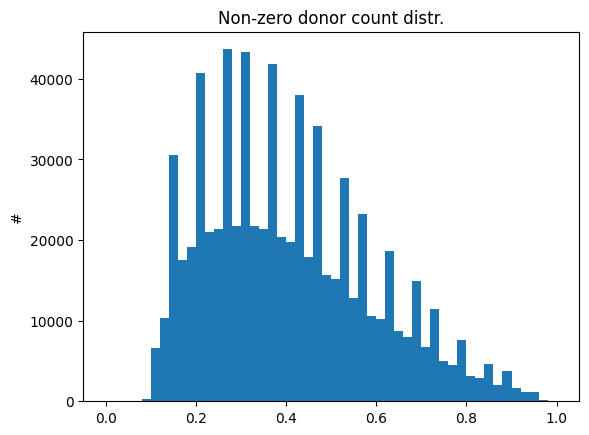

In [54]:
non0s.plot(kind='hist',
           bins=np.linspace(0, 1, 51),
           title="Non-zero donor count distr.",
           ylabel="#")

In [55]:
peaks_min_donors = set(agg_df.loc[:, non0s > min_donors].columns.to_list())

In [56]:
# Density of CA

non0 = np.count_nonzero(caPeaks_1ct_agg.X)
all_ = np.product(caPeaks_1ct_agg.X.shape)
general_ca_density = round(non0 / all_, 2)
print(f'General matrix density: {general_ca_density}')

General matrix density: 0.41


## Peaks filter: min peak score

In [57]:
peak_scores = caPeaks_1ct_agg.var['score']

In [58]:
peak_scores.describe()

count    713283.000000
mean         19.656733
std          28.871417
min           1.028790
25%           5.902470
50%          10.076000
75%          21.414600
max        1017.970000
Name: score, dtype: float64

<Axes: title={'center': 'Peak score distr.'}, ylabel='#'>

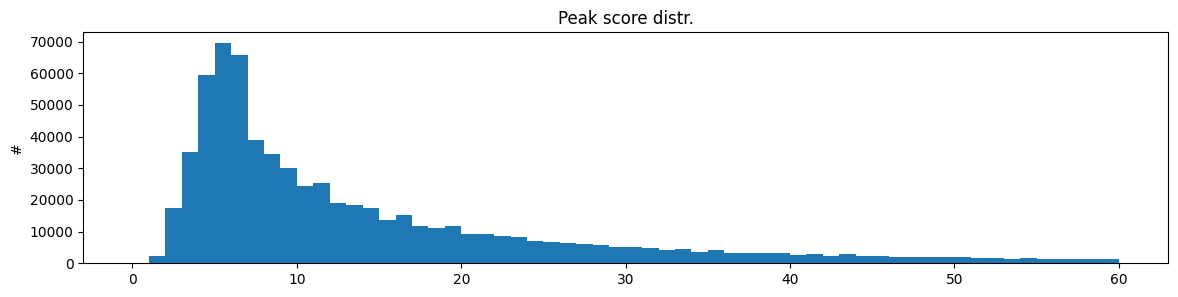

In [59]:
peak_scores.plot(kind='hist',
                 bins=np.linspace(0, 60, 61),
                 figsize=(14,3),
                 title="Peak score distr.",
                 ylabel="#")

In [60]:
peaks_min_score = set(caPeaks_1ct_agg.var[(caPeaks_1ct_agg.var['score'] >= min_score).tolist()].index.tolist())

In [61]:
del agg_df

## CA matrix: final peaks filtering step and export

In [62]:
print(f'Len peaks_hvp = {len(peaks_hvp)}\n' \
      f'peaks_hvp = {list(peaks_hvp)[0:4]}')

Len peaks_hvp = 14710
peaks_hvp = ['chr4:80183689:80184189:501:*:17804', 'chr9:136051745:136052245:501:*:30064', 'chr11:66371571:66372071:501:*:16987', 'chr8:58145560:58146060:501:*:13555']


In [63]:
print(f'Len peaks_markers = {len(peaks_markers)}\n' \
      f'peaks_markers = {list(peaks_markers)[0:4]}')

Len peaks_markers = 2000
peaks_markers = ['chr3:181752138:181752638:501:*:45288', 'chr16:76886101:76886601:501:*:18716', 'chr9:136051745:136052245:501:*:30064', 'chr18:3079571:3080071:501:*:637']


In [64]:
print(f'Len peaks_min_mean = {len(peaks_min_mean)}\n' \
      f'peaks_min_mean = {list(peaks_min_mean)[0:4]}')

Len peaks_min_mean = 373191
peaks_min_mean = ['chr8:142180456:142180956:501:*:33994', 'chr17:40223497:40223997:501:*:11354', 'chr4:169052520:169053020:501:*:36047', 'chr4:123740202:123740702:501:*:26932']


In [65]:
print(f'Len peaks_min_donors = {len(peaks_min_donors)}\n' \
      f'peaks_min_donors = {list(peaks_min_donors)[0:4]}')

Len peaks_min_donors = 628622
peaks_min_donors = ['chr8:142180456:142180956:501:*:33994', 'chr3:8489947:8490447:501:*:1776', 'chr17:40223497:40223997:501:*:11354', 'chr4:169052520:169053020:501:*:36047']


In [66]:
print(f'Len peaks_min_score = {len(peaks_min_score)}\n' \
      f'peaks_min_score = {list(peaks_min_score)[0:4]}')

Len peaks_min_score = 390491
peaks_min_score = ['chr8:142180456:142180956:501:*:33994', 'chr3:8489947:8490447:501:*:1776', 'chr4:169052520:169053020:501:*:36047', 'chr14:100454136:100454636:501:*:21104']


In [67]:
print(f'Len peaks_eqtl = {len(peaks_eqtl)}\n' \
      f'peaks_eqtl = {list(peaks_eqtl)[0:4]}')

Len peaks_eqtl = 437
peaks_eqtl = ['chr6:26223836:26224336:501:*:7804', 'chr3:15323142:15323642:501:*:4430', 'chr15:98745122:98745622:501:*:21280', 'chr16:57644474:57644974:501:*:13407']


In [68]:
# Filter final peaks
final_peaks = list((peaks_hvp | peaks_markers | peaks_eqtl) & (peaks_min_mean | peaks_min_donors | peaks_min_score)) # remove peaks_min_mean or peaks_min_donors

caPeaks_1ct_agg = caPeaks_1ct_agg[:, final_peaks].copy()

len(final_peaks)

17112

In [69]:
# Create CA matrix
ca_peaks_out = caPeaks_1ct_agg.to_df().T
ca_peaks_out = ca_peaks_out.rename_axis('peak_id')

In [70]:
len(ca_peaks_out.columns.tolist())

69

In [71]:
ca_donors = list(set(ca_peaks_out.columns.tolist()) - artifact_donors) # Should be redundand
len(ca_donors)

69

In [72]:
ca_peaks_out = ca_peaks_out[ca_donors]

print(ca_peaks_out.shape)
ca_peaks_out

(17112, 69)


,SAMEA2625592,SAMEA3962524,SAMEA3962389,SAMEA3974247,SAMEA2707499,SAMEA2518322,SAMEA2613912,SAMEA2570435,SAMEA3965165,SAMEA3968753,...,SAMEA3963885,SAMEA3974015,SAMEA2536413,SAMEA2698315,SAMEA2645805,SAMEA3853122,SAMEA3967410,SAMEA4451098,SAMEA2658107,SAMEA2658084
peak_id,,,,,,,,,,,,,,,,,,,,,
chr4:80183689:80184189:501:*:17804,0.106585,0.136013,0.031836,0.063683,0.033921,0.043687,0.000000,0.083195,0.045714,0.059418,...,0.079424,0.036786,0.077980,0.086170,0.090516,0.000000,0.061301,0.0,0.000000,0.000000
chr9:136051745:136052245:501:*:30064,0.070251,0.246505,0.043482,0.003243,0.051376,0.011889,0.062568,0.047295,0.097322,0.053226,...,0.062119,0.053450,0.046885,0.064569,0.094761,0.000000,0.044826,0.0,0.102404,0.000000
chr11:66371571:66372071:501:*:16987,0.063259,0.000000,0.099143,0.118053,0.028230,0.061462,0.074012,0.062318,0.049574,0.046278,...,0.046479,0.058066,0.028388,0.048927,0.012190,0.000000,0.059830,0.0,0.013186,0.053647
chr8:58145560:58146060:501:*:13555,0.051771,0.026830,0.073509,0.056200,0.040390,0.035787,0.024648,0.059486,0.068927,0.039971,...,0.059612,0.044029,0.069453,0.051985,0.013246,0.268042,0.058260,0.0,0.016426,0.000000
chr8:66219794:66220294:501:*:15544,0.028259,0.000000,0.000000,0.005126,0.009959,0.005511,0.000000,0.005359,0.003409,0.005159,...,0.012210,0.006523,0.012300,0.008819,0.002889,0.000000,0.010133,0.0,0.000000,0.073819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr2:8542725:8543225:501:*:2729,0.000629,0.000000,0.000000,0.000000,0.010534,0.008492,0.000000,0.004032,0.002801,0.000000,...,0.002625,0.030527,0.001153,0.005752,0.006875,0.000000,0.002460,0.0,0.005723,0.000000
chr11:61791859:61792359:501:*:14653,0.037056,0.000000,0.050148,0.040153,0.073110,0.042732,0.000000,0.070476,0.072289,0.032245,...,0.046580,0.057808,0.051166,0.045549,0.045226,0.000000,0.058812,0.0,0.033826,0.041760
chr2:71631431:71631931:501:*:20650,0.003709,0.000000,0.003956,0.000000,0.002417,0.000000,0.000000,0.000000,0.002793,0.000000,...,0.001221,0.000000,0.000000,0.004240,0.000000,0.000000,0.000000,0.0,0.000000,0.000000


In [73]:
# Export peak chromatin accessibility
ca_peaks_out.round(6).to_csv(f"data/datasets/hca_brain-organoids_processed/chromatin_accessibility/peak-matrix_rna-qc-cells_norm-reads-in-tss_{cell_type}.tsv", sep='\t')

### CA matrix stats

In [74]:
_, mean_cells_donor, std_cells_donor, _, _, _, _, _ = caPeaks_1ct.obs.groupby('donor_id').size().describe()
_, mean_cells_donor_batch, std_cells_donor_batch, _, _, _, _, _ = caPeaks_1ct.obs.groupby(['donor_id', 'Batch']).size().describe() 

In [75]:
# Stats

with open("data/datasets/hca_brain-organoids_processed/chromatin_accessibility/peaks_stats.tsv", 'a') as f:
    
    msg = f'\n{RUN_ID}\t' \
            f'{cell_type}\t' \
            f'{general_ca_density}\t' \
            f'{n_cells}\t' \
            f'{n_donors}\t' \
            f'{mean_cells_donor}\t' \
            f'{std_cells_donor}\t' \
            f'{n_donor_batch}\t' \
            f'{mean_cells_donor_batch}\t' \
            f'{std_cells_donor_batch}\t' \
            f'{n_peaks_og}\t' \
            f'{n_peaks_min_cells}\t' \
            f'{n_peaks_post_min_cells}\t' \
            f'{len(peaks_eqtl)}\t' \
            f'{len(peaks_hvp)}\t' \
            f'{len(peaks_markers)}\t' \
            f'{len(peaks_min_mean)}\t' \
            f'{len(peaks_min_donors)}\t' \
            f'{len(peaks_min_score)}\t' \
            f'{ca_peaks_out.shape[0]}\t' \
            f'{ca_peaks_out.shape[1]}'

    
    f.write(msg)
    
    print(msg)


sep8	Midbrain-EN	0.41	24838	69	359.9710144927536	441.9596724687238	288	3.870656069814555	32.359052327598285	736845	23562	713283	437	14710	2000	373191	628622	390491	17112	69


In [76]:
del ca_peaks_out
del caPeaks_1ct

# COV: peak locations

In [77]:
peak_locs = caPeaks_1ct_agg.var[['peak_name', 'chr', 'start', 'end']].copy()
peak_locs['start'] = peak_locs['start'] - 1

peak_locs

,peak_name,chr,start,end
peak_name,,,,
chr4:80183689:80184189:501:*:17804,chr4:80183689:80184189:501:*:17804,chr4,80183688,80184189
chr9:136051745:136052245:501:*:30064,chr9:136051745:136052245:501:*:30064,chr9,136051744,136052245
chr11:66371571:66372071:501:*:16987,chr11:66371571:66372071:501:*:16987,chr11,66371570,66372071
chr8:58145560:58146060:501:*:13555,chr8:58145560:58146060:501:*:13555,chr8,58145559,58146060
chr8:66219794:66220294:501:*:15544,chr8:66219794:66220294:501:*:15544,chr8,66219793,66220294
...,...,...,...,...
chr2:8542725:8543225:501:*:2729,chr2:8542725:8543225:501:*:2729,chr2,8542724,8543225
chr11:61791859:61792359:501:*:14653,chr11:61791859:61792359:501:*:14653,chr11,61791858,61792359
chr2:71631431:71631931:501:*:20650,chr2:71631431:71631931:501:*:20650,chr2,71631430,71631931


In [78]:
peak_locs.to_csv(f"data/datasets/hca_brain-organoids_processed/covariates/peak_locations_{cell_type}.tsv", sep='\t', index=False)

In [79]:
del peak_locs

# COV: CA PCs

In [80]:
sc.pp.pca(caPeaks_1ct_agg) # Filtered for final peak set

In [81]:
ca_pcs = pd.DataFrame(caPeaks_1ct_agg.obsm['X_pca'][:, 0:20]).set_index(caPeaks_1ct_agg.obs_names)
ca_pcs.columns = [f'caPC_{str(i)}' for i in range(1, 21)]
ca_pcs = ca_pcs.T
ca_pcs = ca_pcs.rename_axis('id')

In [82]:
# ! Important that this doesn't change the sample nr! 2 cells above
ca_pcs = ca_pcs[ca_donors]

print(ca_pcs.shape)
ca_pcs

(20, 69)


,SAMEA2625592,SAMEA3962524,SAMEA3962389,SAMEA3974247,SAMEA2707499,SAMEA2518322,SAMEA2613912,SAMEA2570435,SAMEA3965165,SAMEA3968753,...,SAMEA3963885,SAMEA3974015,SAMEA2536413,SAMEA2698315,SAMEA2645805,SAMEA3853122,SAMEA3967410,SAMEA4451098,SAMEA2658107,SAMEA2658084
id,,,,,,,,,,,,,,,,,,,,,
caPC_1,-0.833009,-0.988963,-0.956736,-0.892848,-0.868152,-0.855707,-1.076182,-0.868759,-0.881463,-0.852013,...,-0.865699,-0.884957,-0.907388,-0.905536,-0.978341,-0.844652,-0.818302,60.943748,-0.823308,-0.848025
caPC_2,-0.583323,-0.567706,-0.354576,-0.644666,-0.527301,-0.578627,-0.554982,-0.591228,-0.360594,-0.501642,...,-0.569324,-0.480508,-0.550334,-0.479868,-0.421251,-0.641343,-0.592888,-0.146742,-0.542202,-0.756781
caPC_3,-0.454280,-0.634951,-0.293895,-0.464701,-0.342100,-0.439448,-0.519894,-0.413981,-0.441137,-0.446492,...,-0.442509,-0.342260,-0.449668,-0.407471,-0.560290,-0.369007,-0.406461,0.052212,-0.548694,-0.383703
caPC_4,-0.287326,-0.262018,-0.398929,-0.479800,-0.295943,-0.264601,-0.308636,-0.301395,-0.343275,-0.238302,...,-0.328584,-0.294283,-0.376817,-0.279538,-0.297026,-0.779251,-0.300190,0.251109,-0.345829,-0.460630
caPC_5,-0.450008,-0.478755,-0.270596,-0.498714,-0.528550,-0.594733,-1.046884,-0.485046,-0.309019,-0.534529,...,-0.463821,-0.429169,-0.575869,-0.354284,-0.482287,-0.465236,-0.492712,0.090345,-0.527347,-0.771521
caPC_6,-0.445178,-0.575586,-0.151300,-0.580741,-0.246496,-0.470394,-0.589967,-0.384412,-0.152442,-0.382056,...,-0.432435,-0.175802,-0.459903,-0.256472,-0.304119,-0.338432,-0.394334,-0.074294,-0.399910,-0.754565
caPC_7,-0.538508,-0.711320,-0.138111,-0.652231,-0.408301,-0.503983,-0.703432,-0.534095,-0.329776,-0.469785,...,-0.534734,-0.259061,-0.501381,-0.323834,-0.643693,0.034068,-0.509269,0.093370,-0.506576,-0.659265
caPC_8,-0.415734,-0.675937,-0.056566,-0.508115,-0.292782,-0.420246,18.075390,-0.370519,-0.165996,-0.374243,...,-0.344471,-0.157810,-0.431664,-0.303762,-0.368442,1.369039,-0.375301,0.055705,-0.196944,-0.555925
caPC_9,-0.361302,-0.958465,0.239932,-0.498612,-0.205471,-0.405743,-1.699522,-0.317894,-0.021040,-0.298664,...,-0.319529,-0.079769,-0.413175,-0.154493,-0.211779,17.456425,-0.373180,-0.020670,-0.337355,-0.437503


In [83]:
ca_pcs.to_csv(f"data/datasets/hca_brain-organoids_processed/covariates/ca_pcs_{cell_type}.tsv", sep='\t')

In [84]:
del ca_pcs
del caPeaks_1ct_agg

# COV: Population structure

In [85]:
gt_pcs = pd.read_csv(os.path.join(HCA_BORGS_PROJ, "Genotypes/GT_PCs.tsv"), sep="\t", index_col=0)
gt_pcs_matrixQTL = gt_pcs.T
gt_pcs_matrixQTL = gt_pcs_matrixQTL.rename_axis('id')
gt_pcs_matrixQTL = gt_pcs_matrixQTL[ca_donors]

print(gt_pcs_matrixQTL.shape)
gt_pcs_matrixQTL

(20, 69)


iid,SAMEA2625592,SAMEA3962524,SAMEA3962389,SAMEA3974247,SAMEA2707499,SAMEA2518322,SAMEA2613912,SAMEA2570435,SAMEA3965165,SAMEA3968753,...,SAMEA3963885,SAMEA3974015,SAMEA2536413,SAMEA2698315,SAMEA2645805,SAMEA3853122,SAMEA3967410,SAMEA4451098,SAMEA2658107,SAMEA2658084
id,,,,,,,,,,,,,,,,,,,,,
PC1,-36.099750,12.186271,4.674102,2.513582,36.567543,0.094868,-44.876938,22.046660,-14.546681,-31.988290,...,-45.389390,-19.776396,37.227420,-28.362892,5.062119,-43.581306,2.542705,-12.098614,-3.758722,-7.199219
PC2,69.155190,42.351612,6.302846,42.838642,24.418850,28.659481,-26.285961,58.941704,13.121081,20.735870,...,578.792850,5.389915,29.959509,-27.927677,17.896296,12.955510,22.273016,15.852032,-17.553230,13.413182
PC3,54.365560,10.103840,-0.185648,20.748500,56.386528,20.669409,-132.768070,37.135384,7.121950,31.961624,...,-521.950900,36.380917,7.322402,1.648885,63.705715,45.188217,0.096000,3.692584,-21.497366,46.895866
PC4,8.240096,-94.013070,35.015190,-6.323660,49.088190,9.481113,-639.104000,18.699808,-17.582450,-18.455887,...,-901.205300,-8.483903,4.514056,-32.976494,7.872817,18.429962,-23.513031,-5.239960,-10.106815,-19.546944
PC5,-5.430482,-3.526762,3.094576,-47.334480,-1.617828,22.285526,-85.408226,69.061970,-32.255928,-13.088952,...,563.941200,27.987051,20.821611,-31.880617,-31.429237,27.995300,44.935425,4.907794,-1.862093,-9.918574
PC6,7.309116,5.925176,22.390940,-32.809708,-71.204760,-30.922153,-492.477700,-67.375480,-40.839900,-21.378864,...,270.644130,-15.383025,-4.850675,-43.034910,-26.485926,-35.752674,-61.912540,-7.100158,10.962170,6.438612
PC7,-14.493244,-43.594402,-26.352718,-3.031651,4.270656,-16.092543,156.371300,-23.757479,-15.643868,28.592112,...,269.105530,7.865913,-5.095608,-18.378374,-70.128140,47.433018,-53.017044,58.766727,7.909484,23.455002
PC8,-20.599740,-6.027317,13.858808,2.906827,-3.997136,-1.781297,-407.644650,-10.987617,-1.930764,57.042760,...,-393.916500,-15.201972,-4.225716,36.437107,44.648506,85.883910,20.081114,-57.222670,32.048443,14.720870
PC9,6.205075,17.676556,-11.894598,-10.186135,4.609481,21.162674,1240.363200,-24.735409,17.155119,12.907979,...,-186.866290,-58.514595,-12.799575,2.044739,24.249603,-34.295834,25.963253,0.226498,40.589954,-2.595212


In [86]:
parent_dir = "data/datasets/hca_brain-organoids_processed/covariates/"

if not os.path.isdir(parent_dir):
    os.makedirs(parent_dir)

In [87]:
gt_pcs_matrixQTL.to_csv(f"data/datasets/hca_brain-organoids_processed/covariates/genotype_pcs_{cell_type}.tsv", sep='\t')

In [88]:
del gt_pcs
del gt_pcs_matrixQTL

# Genotype

In [89]:
gt = pd.read_csv('data/datasets/hca_brain-organoids_processed/covariates/genotype.tsv', sep='\t', header=0, index_col=0).rename_axis('snp_id')
gt = gt.rename(index=lambda x: 'chr' + str(x))

In [90]:
snps_set = gt.index.tolist()

In [91]:
gt = gt[ca_donors]
gt

,SAMEA2625592,SAMEA3962524,SAMEA3962389,SAMEA3974247,SAMEA2707499,SAMEA2518322,SAMEA2613912,SAMEA2570435,SAMEA3965165,SAMEA3968753,...,SAMEA3963885,SAMEA3974015,SAMEA2536413,SAMEA2698315,SAMEA2645805,SAMEA3853122,SAMEA3967410,SAMEA4451098,SAMEA2658107,SAMEA2658084
snp_id,,,,,,,,,,,,,,,,,,,,,
chr1_89599_A_T,2.0,0.0,1.0,NaN,0.0,NaN,2.0,1.0,2.0,2.0,...,NaN,2.0,2.0,1.0,2.0,2.0,2.0,2.0,NaN,NaN
chr1_94986_C_T,2.0,2.0,2.0,NaN,2.0,NaN,2.0,2.0,2.0,2.0,...,1.0,1.0,2.0,2.0,2.0,0.0,2.0,2.0,0.0,NaN
chr1_94996_A_AT,2.0,0.0,2.0,NaN,0.0,NaN,2.0,1.0,2.0,2.0,...,2.0,2.0,2.0,1.0,2.0,NaN,2.0,2.0,2.0,NaN
chr1_95068_G_A,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,0.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0
chr1_96305_C_T,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,...,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr22_50780959_T_C,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0
chr22_50781276_G_A,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0
chr22_50783303_T_C,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0


In [92]:
gt.to_csv(f'data/datasets/hca_brain-organoids_processed/covariates/genotype_NA_{cell_type}.tsv', sep='\t', na_rep='NaN')

In [93]:
del gt

# SNP locations

In [94]:
snps = pd.read_csv("data/datasets/hca_brain-organoids_processed/covariates/genotype.vcf",
                   sep="\t",
                   comment="#",
                   header=None,
                   names=["CHROM", "POS", "ID", "REF", "ALT", "QUAL", "FILTER", "INFO", "FORMAT", "SAMEA2536416", "SAMEA3854313", "SAMEA3853161", "SAMEA3966392", "SAMEA2625592", "SAMEA2698309", "SAMEA3962624", "SAMEA3965165", "SAMEA2595426", "SAMEA3962389", "SAMEA3973854", "SAMEA3847031", "SAMEA2547622", "SAMEA3854308", "SAMEA3964906", "SAMEA2536410", "SAMEA3735541", "SAMEA2590621", "SAMEA2698315", "SAMEA2445784", "SAMEA3973848", "SAMEA3962524", "SAMEA3485962", "SAMEA2609965", "SAMEA3851971", "SAMEA4089454", "SAMEA2613912", "SAMEA3963885", "SAMEA3963884", "SAMEA2613897", "SAMEA4089453", "SAMEA3851966", "SAMEA3974241", "SAMEA4343052", "SAMEA3962619", "SAMEA3853122", "SAMEA3974015", "SAMEA2518325", "SAMEA2433566", "SAMEA2459959", "SAMEA2675459", "SAMEA2682671", "SAMEA2645805", "SAMEA2711371", "SAMEA2593858", "SAMEA2445790", "SAMEA2518322", "SAMEA2547619", "SAMEA2627577", "SAMEA2547637", "SAMEA3977051", "SAMEA2445779", "SAMEA2609971", "SAMEA3974247", "SAMEA2658107", "SAMEA3754205", "SAMEA2547644", "SAMEA2678742", "SAMEA2474454", "SAMEA2627566", "SAMEA2518334", "SAMEA3967410", "SAMEA2536404", "SAMEA2627578", "SAMEA2518324", "SAMEA3968753", "SAMEA2547899", "SAMEA3754201", "SAMEA2570435", "SAMEA2658084", "SAMEA4451098", "SAMEA2678738", "SAMEA2547633", "SAMEA2609972", "SAMEA2707499", "SAMEA2555017", "SAMEA2420640", "SAMEA4451109", "SAMEA3448738", "SAMEA2627141", "SAMEA3485958", "SAMEA2536413", "SAMEA2464819", "SAMEA2627567", "SAMEA2645814"],
                   index_col=False
                  )

snps = snps[['ID', 'CHROM', 'POS']].rename(columns={'ID': 'snp_id', 'CHROM': 'chr', 'POS': 'pos'})
snps = snps.set_index('snp_id')

In [95]:
snps = snps.loc[snps_set]
snps

,chr,pos
snp_id,,
chr1_89599_A_T,chr1,89599
chr1_94986_C_T,chr1,94986
chr1_94996_A_AT,chr1,94996
chr1_95068_G_A,chr1,95068
chr1_96305_C_T,chr1,96305
...,...,...
chr22_50780959_T_C,chr22,50780959
chr22_50781276_G_A,chr22,50781276
chr22_50783303_T_C,chr22,50783303


In [96]:
snps.to_csv(f"data/datasets/hca_brain-organoids_processed/covariates/snp_locations_{cell_type}.tsv", sep='\t')

In [97]:
del snps